In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
np.set_printoptions(suppress=True)

import os
#os.environ["OPT"] = '1'
os.environ["GPU"] = '1'
import random
from tqdm import trange
from tinygrad.helpers import prod
from tinygrad.tensor import Tensor
from tinygrad.nn import Conv2d
from tinygrad.nn.optim import Adam, get_parameters
from datasets import fetch_mnist

X_train, Y_train, X_test, Y_test = fetch_mnist()
mu, stddev = X_train.mean(), (X_train.var() ** 0.5)
X_train = (X_train.astype(np.float32).reshape(-1, 1, 28, 28) - mu) / stddev
X_test = (X_test.astype(np.float32).reshape(-1, 1, 28, 28) - mu) / stddev
X_train.mean(), X_train.var()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


(-3.4560264e-07, 0.99999964)

In [2]:
def upsample(x):
  bs,c,py,px = x.shape
  return x.reshape(bs, c, py, 1, px, 1).expand(bs, c, py, 2, px, 2).reshape(bs, c, py*2, px*2)

H = 64
EPS = 1e-8
class AutoEncoder:
  def __init__(self):
    self.emb = Tensor.glorot_uniform(16, 4, requires_grad=True)  # KxD, K=8 latent space, D=4 dimensionality of embedding vector
    # downsample
    self.c1 = Conv2d(1, 16, kernel_size=3, stride=2)
    self.c2 = Conv2d(16, H, kernel_size=3, stride=2)
    self.c3 = Conv2d(H, H, kernel_size=3, padding=1)
    self.c4 = Conv2d(H, 4, kernel_size=3, stride=2)
    # upsample
    self.d1 = Conv2d(4, H, kernel_size=3, padding=1)
    self.d2 = Conv2d(H, H, kernel_size=3, padding=1)
    self.d3 = Conv2d(H, 16, kernel_size=3, padding=(0,1,0,1))
    self.d4 = Conv2d(16, 1, kernel_size=3)
    
  def encode(self, x):
    return x.sequential([self.c1, Tensor.relu,
                         self.c2, Tensor.relu,
                         self.c3, Tensor.relu,
                         self.c4])
  
  def decode(self, x):
    return x.sequential([upsample, self.d1, Tensor.relu,
                         upsample, self.d2, Tensor.relu,
                         upsample, self.d3, Tensor.relu,
                         upsample, self.d4])
    
    
  def __call__(self, x):
    inputs = self.encode(x)
    flat_input = inputs.permute(0,2,3,1).reshape(-1, 4)
    
    # https://github.com/zalandoresearch/pytorch-vq-vae/blob/master/vq-vae.ipynb
    distances = flat_input.square().sum(axis=1, keepdim=True) + self.emb.square().sum(axis=1) - 2 * (flat_input @ self.emb.transpose())
    encoding_min = distances.min(axis=1, keepdim=True)
    encodings = (-(distances-encoding_min)+EPS).relu()/EPS   # hacks for argmin
    quantized = encodings @ self.emb
    quantized_pl = flat_input + (quantized - flat_input).detach()   # allow the gradient to flow
    latent = quantized_pl.reshape(inputs.shape[0], inputs.shape[2], inputs.shape[3], inputs.shape[1]).permute(0,3,1,2)    
    
    codebook_loss = encoding_min.mean()
    commitment_loss = (quantized.detach() - flat_input).square().mean()   # needed to not update codebook too fast
    
    return self.decode(latent), codebook_loss, commitment_loss
  
model = AutoEncoder()
opt = Adam(get_parameters(model), lr=1e-3)
losses = []
model.encode(Tensor(X_train[0:10])), model(Tensor(X_train[0:10])), sum([prod(x.shape) for x in get_parameters(model)])

(<Tensor <LB (10, 4, 2, 2) op:BinaryOps.ADD> with grad None>,
 (<Tensor <LB (10, 1, 28, 28) op:BinaryOps.ADD> with grad None>,
  <Tensor <LB (1,) op:BinaryOps.MUL> with grad None>,
  <Tensor <LB (1,) op:BinaryOps.MUL> with grad None>),
 97413)

0.367845 0.067694 0.016923: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:40<00:00,  9.99it/s]


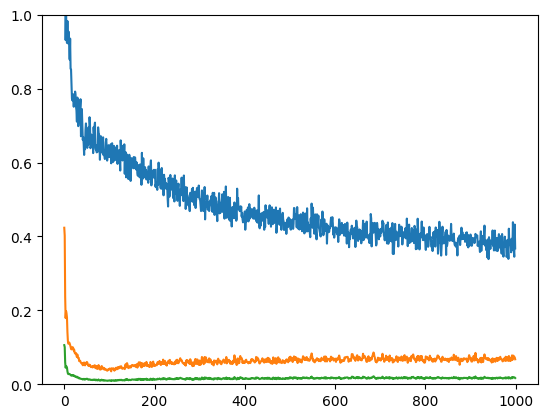

In [3]:
BS = 64
for i in (t:=trange(1000)):
  inp = Tensor(X_train[[random.randint(0, X_train.shape[0]-1) for _ in range(BS)]])
  ret, codebook_loss, commitment_loss = model(inp)
  reconstruction_loss = (ret - inp).square().mean()
  loss = reconstruction_loss + codebook_loss + 0.25*commitment_loss
  opt.zero_grad()
  loss.backward()
  opt.step()
  losses.append((reconstruction_loss.numpy()[0], codebook_loss.numpy()[0], commitment_loss.numpy()[0]))
  t.set_description(f"{losses[-1][0]:f} {losses[-1][1]:f} {losses[-1][2]:f}")
plt.ylim(0,1)
plot(losses)

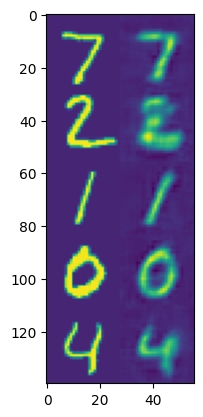

In [4]:
real = Tensor(X_test[0:5]).reshape(-1, 28)
rec = model(Tensor(X_test[0:5]))[0]
imshow(real.cat(rec.reshape(-1, 28), dim=1).numpy())